In [1]:
import sys
sys.path.append('d:\\01_User Folders\\Legal_backend')

In [2]:
from legal_backend.r_to_py.r_to_py import init_R
from legal_backend.bartCause.bart_cause import BARTCause
from legal_backend.pip_utils import prepare_train_data, rmse, nrmse, r_square, coverage_rate, kfold_indices, prepare_permute_data, statistic
from legal_backend.pipeline_analysis.read_pattern import read_pattern

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from scipy.stats import permutation_test
from matplotlib import pyplot as plt
from scipy import stats
from collections import Counter

In [4]:
init_R()

### Load Data

In [5]:
#load csv files and load possible laws
df = pd.read_csv('data/goodsam_all.csv')

In [6]:
df.rename(columns={'death-rate-2013-2016':'delta_death_rate'}, inplace=True)
df['Urbanicity'] = df['Urbanicity'].map({'Urban':1, 'Rural':0})
df.columns

Index(['Percent-of-Population-Under-15-(2013-2017)',
       'Percent-of-Population-Aged-15-to-64-(2013-2017)',
       'Percent-of-Population-65+-(2013-2017)',
       'Percent-of-Population-White-(non-Hispanic)-(2013-2017)',
       'Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Hispanic-or-Latino-(2013-2017)',
       'Percent-of-Population-Asian-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-at-Least-a-High-School-Diploma-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-a-Bachelor's-Degree-or-More-(2013-2017)',
       'Poverty-Rate-(2013-2017)', 'Median-Household-Income-(2013-2017)',
       'Unemployment-Rate-(2013-2017)',
       'Percent-of-Residents-with-a-Disability-(Aged-18-64)-(2013-2017)',
       'Percent-of-Popualtion-Employed-in-Mini

###  Input Patterns

In [7]:
df_sub = df.copy(deep=True)
conds = []
conds.append("df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<0.009")
conds.append("df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']>0.004")
conds.append("df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']<0.307")
for cond in conds:
    df_sub = df_sub.loc[eval(cond)].reset_index(drop=True)
law = 'goodsam-cs_Prosecution'

In [8]:
print(law)
print("number of counties within subgroup:",df_sub.shape[0])
# df_sub.head()

goodsam-cs_Prosecution
number of counties within subgroup: 843


In [9]:
print(Counter(df_sub[law]))
num_instances = list(Counter(df_sub[law]).values())
imbalance_ratio = min(num_instances) / max(num_instances)
print("Imbalanced Data Detected! Imbalnce Ratio:", imbalance_ratio) if (imbalance_ratio < 0.1) else print("Imbalnce Ratio:",imbalance_ratio)

Counter({1.0: 599, 0.0: 244})
Imbalnce Ratio: 0.4073455759599332


In [10]:
X_train_scaled, y_train, Z_train, X_test_scaled, y_test, Z_test = prepare_train_data(df_sub, law)

In [11]:
bart_eval = BARTCause()
bart_eval.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

In [12]:
# evaluate BART fit on response surface
newData = np.concatenate((X_test_scaled, Z_test), axis=1)

y_test_predicted_, y_test_predicted_lb, y_test_predicted_ub = bart_eval.predict(newData, infer_type="mu")

y_test_predicted = y_test_predicted_[:,np.newaxis]
y_test_predicted_lb = y_test_predicted_lb[:,np.newaxis]
y_test_predicted_ub = y_test_predicted_ub[:,np.newaxis]

In [13]:
print("quantile(0.05-0.95): [",np.quantile(y_test, 0.05),",", np.quantile(y_test, 0.95),"]")
print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))
print("r square:", r_square(y_test,y_test_predicted), "\n", "nrmse:", nrmse(y_test, y_test_predicted, 'range'))
# print("coverage rate:", coverage_rate(y_test, y_test_predicted_lb, y_test_predicted_ub))

quantile(0.05-0.95): [ 11.781299542827616 , 127.42743961736396 ]
BART RMS: 35.56062420117145 
 Baseline RMS: 43.17957642401473
r square: 0.32176219186890054 
 nrmse: 0.10287347880807751


#### K-fold Cross Validation

In [14]:
fold_indices = kfold_indices(df_sub, 5)

In [13]:
def cross_validation_test(df, law, fold_indices):
    bartCause = BARTCause()
    
    X_df = df.iloc[:, :27].to_numpy()
    M = X_df.shape[1] 

    y = df[['delta_death_rate']].to_numpy()
    Z_law = df[[law]].to_numpy()
    # numerical columns
    num_cols = [c for c in range(M) if len(np.unique(X_df[:, c])) > 2] 

    scores = []

    for fold, (train_indices, test_indices) in enumerate(fold_indices):
        print("fold:",fold)
        X_train, y_train, Z_train = X_df[train_indices,:], y[train_indices,:], Z_law[train_indices,:]
        X_test, y_test, Z_test = X_df[test_indices,:], y[test_indices,:], Z_law[test_indices,:]

        # standardize data
        scaler_ = preprocessing.StandardScaler().fit(X_train[:,num_cols])
        X_train_scaled = np.copy(X_train)
        X_train_scaled[:,num_cols] = scaler_.transform(X_train[:,num_cols])

        X_test_scaled = np.copy(X_test)
        X_test_scaled[:,num_cols] = scaler_.transform(X_test[:,num_cols])
        
        # Train the model on the training data
        bartCause.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

        # Make predictions on the test data
        test_data = np.concatenate((X_test_scaled, Z_test), axis=1)
        y_test_pred_, _, _ = bartCause.predict(test_data, infer_type="mu")
        y_test_pred = y_test_pred_[:,np.newaxis]
        
        # Calculate the accuracy score for this fold
        fold_score = nrmse(y_test, y_test_pred, 'range')
        
        # Append the fold score to the list of scores
        scores.append(fold_score)

    # Calculate the mean accuracy across all folds
    mean_score = np.mean(scores)

    return scores, mean_score

In [16]:
scores, mean_score = cross_validation_test(df_sub, law, fold_indices)
print("K-Fold Cross-Validation Scores:", scores)
print("Mean Score:", mean_score)

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.19721383933654238, 0.18236883991242064, 0.21179268686266461, 0.17022189621995654, 0.10603563517463505]
Mean Score: 0.17352657950124387


#### Compute ITE

In [17]:
bartCause = BARTCause()
X_scaled, y, Z_law = prepare_permute_data(df_sub, law)
bartCause.fit(X_scaled, y, Z_law, n_samples=1000,  n_burn=200,  n_chains=5)

In [18]:
# evaluate BART fit on response surface
newData = np.concatenate((X_scaled, Z_law), axis=1)

predicted_Z1, _, _ = bartCause.predict(newData, infer_type="mu.1")
predicted_Z0, _, _ = bartCause.predict(newData, infer_type="mu.0")
# predicted_Z1 = predicted_Z1_[:,np.newaxis]
# predicted_Z0 = predicted_Z0_[:,np.newaxis]
mean_law0 = predicted_Z0.mean()
mean_law1 = predicted_Z1.mean()
avg_ite = (predicted_Z1 - predicted_Z0).mean()
std_ite = (predicted_Z1 - predicted_Z0).std()
print("Avg ITE:", avg_ite,"Stdev ITE:",std_ite)

Avg ITE: 6.818436396210012 Stdev ITE: 3.475102475658373


In [19]:
alternative_str = 'less' if avg_ite > 0 else 'greater'

#### Permutation test

In [20]:
res_permute = permutation_test((predicted_Z0, predicted_Z1), statistic, alternative=alternative_str)
res_permute

PermutationTestResult(statistic=-6.818436396210018, pvalue=0.0001, null_distribution=array([-0.75648186, -0.25369641,  0.20903521, ...,  1.21517294,
       -0.27266515,  2.21677597]))

#### Paired Samples t-Test (Dependent Samples t-Test)

In [21]:
res_ttest = stats.ttest_rel(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_ttest

TtestResult(statistic=-56.93420012752554, pvalue=3.1599248251251807e-291, df=842)

#### Mann-Whitney U Test / Wilcoxon Rank-Sum Test (No normal distribution assumption)

In [22]:
res_mannwhitneyu = stats.mannwhitneyu(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_mannwhitneyu

MannwhitneyuResult(statistic=289945.0, pvalue=3.055554973857589e-11)

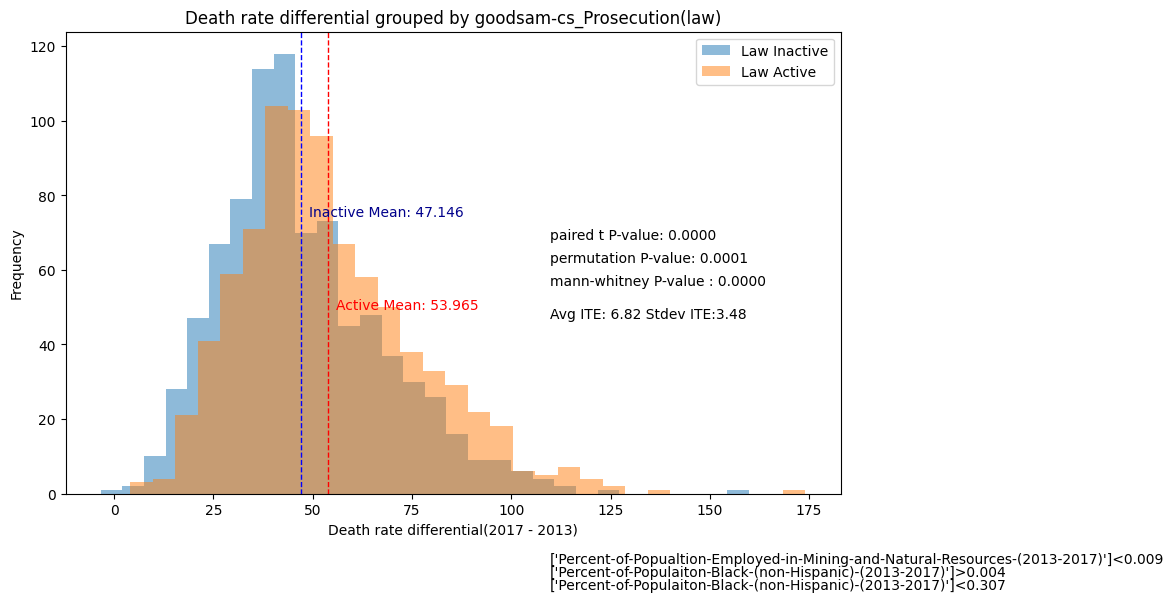

In [23]:

plt.figure(figsize=(10, 6))
plt.hist(predicted_Z0, bins=30, alpha=0.5, label='Law Inactive')
plt.hist(predicted_Z1, bins=30, alpha=0.5, label='Law Active')

plt.axvline(mean_law0, color='blue', linestyle='dashed', linewidth=1)
plt.text(mean_law0 + 2, plt.ylim()[1] * 0.6, f'Inactive Mean: {mean_law0:.3f}', color='darkblue')
plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_law1 + 2, plt.ylim()[1] * 0.4, f'Active Mean: {mean_law1:.3f}', color='red')

plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.45, f'mann-whitney P-value : {res_mannwhitneyu.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.5, f'permutation P-value: {res_permute.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.55, f'paired t P-value: {res_ttest.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.38, f'Avg ITE: {avg_ite:.2f} Stdev ITE:{std_ite:.2f}', color='black', fontsize=10)

if len(conds) > 0:
    for i,cond in enumerate(conds):
        cond_text = cond[6:] 
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * -0.15 -3.5 * i, cond_text, color='black')


plt.xlabel('Death rate differential(2017 - 2013)')
plt.ylabel('Frequency')
plt.title('Death rate differential grouped by '+ law+'(law)')
plt.legend()
# plt.savefig("demo_res/sub_law_"+law+".png")
plt.show()

GIVEN PATTERN RUN BART

In [10]:
from legal_backend.r_to_py.r_to_py import init_R
from legal_backend.bartCause.bart_cause import BARTCause
from legal_backend.pip_utils import prepare_train_data, rmse, nrmse, r_square, coverage_rate, kfold_indices, prepare_permute_data, statistic
from legal_backend.pipeline_analysis.read_pattern import read_pattern

In [24]:
df_pt = pd.read_csv("data/patterns_for_opioid_death.csv")
df_sub = pd.read_csv("data/goodsam_all.csv")

In [25]:
filterd_patterns_data = dict()
patterns_constraints = dict()
patterns_laws = dict()


In [26]:
# for i in range(df_pt.shape[0]):
for i in range(26,30):
    print(i)
    _, df_idx, conds, law = read_pattern(df_pt.iloc[i]['description'], 'df_sub', df_sub)
    filterd_patterns_data[i] = df_idx
    patterns_constraints[i] = conds
    patterns_laws[i] = law

26
{'Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)': {'lb': -inf, 'ub': 0.00865000020712614}, 'goodsam-cs_Charge': {'lb': 0.5, 'ub': inf}}
Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017) {'lb': -inf, 'ub': 0.00865000020712614}
goodsam-cs_Charge {'lb': 0.5, 'ub': inf}
27
{'Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)': {'lb': -inf, 'ub': 0.00865000020712614}, 'Number-of-Substance-Use-Facilities-(As-of-March-2023)': {'lb': 2.0, 'ub': inf}, 'goodsam-law': {'lb': 0.5, 'ub': inf}}
Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017) {'lb': -inf, 'ub': 0.00865000020712614}
Number-of-Substance-Use-Facilities-(As-of-March-2023) {'lb': 2.0, 'ub': inf}
goodsam-law {'lb': 0.5, 'ub': inf}
28
{'MDsPerCapita': {'lb': 9.170000076293945, 'ub': inf}, 'goodsam-cs_Charge': {'lb': 0.5, 'ub': inf}}
MDsPerCapita {'lb': 9.170000076293945, 'ub': inf}
goodsam-cs_Charge {'lb': 0.5, 'ub': inf}
29
{'Percent

CHECK CONTENTS

In [27]:
for data in filterd_patterns_data:
    print(data)
    print(filterd_patterns_data[data])

26
[4, 7, 16, 22, 27, 34, 35, 36, 38, 40, 44, 47, 48, 50, 51, 56, 57, 58, 61, 67, 70, 71, 72, 73, 76, 81, 82, 83, 85, 88, 91, 92, 95, 98, 100, 103, 110, 111, 112, 123, 132, 133, 142, 152, 158, 167, 170, 175, 176, 179, 183, 184, 189, 201, 203, 204, 208, 211, 212, 213, 216, 218, 219, 220, 223, 225, 228, 243, 247, 248, 251, 259, 260, 262, 265, 271, 274, 276, 278, 281, 290, 292, 297, 298, 300, 301, 305, 306, 307, 308, 309, 311, 312, 313, 314, 316, 317, 318, 319, 321, 322, 325, 326, 328, 331, 332, 333, 334, 342, 352, 359, 360, 362, 364, 365, 367, 368, 371, 374, 375, 381, 382, 385, 388, 390, 391, 394, 398, 399, 401, 403, 405, 406, 408, 409, 411, 412, 413, 414, 416, 419, 421, 424, 425, 427, 430, 431, 438, 439, 440, 441, 443, 445, 446, 447, 450, 452, 453, 454, 455, 458, 459, 461, 470, 472, 474, 475, 476, 478, 489, 490, 493, 498, 501, 504, 505, 506, 509, 510, 517, 522, 524, 528, 529, 530, 538, 544, 547, 549, 550, 558, 574, 595, 599, 600, 605, 606, 612, 615, 618, 622, 626, 631, 635, 637, 639, 64

In [28]:
for data in patterns_constraints:
    print(data)
    print(patterns_constraints[data])

26
["df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<=0.00865000020712614"]
27
["df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<=0.00865000020712614", "df_sub['Number-of-Substance-Use-Facilities-(As-of-March-2023)']>=2.0"]
28
["df_sub['MDsPerCapita']>=9.170000076293945"]
29
["df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<=0.00865000020712614", "df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']>=0.0042500002309679985", "df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']<=0.30664998292922974"]


In [29]:
for data in patterns_laws:
    print(data)
    print(patterns_laws[data])

26
goodsam-cs_Charge
27
goodsam-law
28
goodsam-cs_Charge
29
goodsam-cs_Prosecution


RUNNING BART ON EACH PATTERN

In [30]:
def patternBART(df_sub, law):
    X_train_scaled, y_train, Z_train, X_test_scaled, y_test, Z_test = prepare_train_data(df_sub, law)

    bart_eval = BARTCause()
    bart_eval.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

    # evaluate BART fit on response surface
    newData = np.concatenate((X_test_scaled, Z_test), axis=1)

    y_test_predicted_, y_test_predicted_lb, y_test_predicted_ub = bart_eval.predict(newData, infer_type="mu")

    y_test_predicted = y_test_predicted_[:,np.newaxis]
    y_test_predicted_lb = y_test_predicted_lb[:,np.newaxis]
    y_test_predicted_ub = y_test_predicted_ub[:,np.newaxis]

    print("quantile(0.05-0.95): [",np.quantile(y_test, 0.05),",", np.quantile(y_test, 0.95),"]")
    print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))
    print("r square:", r_square(y_test,y_test_predicted), "\n", "nrmse:", nrmse(y_test, y_test_predicted, 'range'))
    # print("coverage rate:", coverage_rate(y_test, y_test_predicted_lb, y_test_predicted_ub))

    fold_indices = kfold_indices(df_sub, 5)

    scores, mean_score = cross_validation_test(df_sub, law, fold_indices)
    print("K-Fold Cross-Validation Scores:", scores)
    print("Mean Score:", mean_score)

    bartCause = BARTCause()
    X_scaled, y, Z_law = prepare_permute_data(df_sub, law)
    bartCause.fit(X_scaled, y, Z_law, n_samples=1000,  n_burn=200,  n_chains=5)

    # evaluate BART fit on response surface
    newData = np.concatenate((X_scaled, Z_law), axis=1)

    predicted_Z1, _, _ = bartCause.predict(newData, infer_type="mu.1")
    predicted_Z0, _, _ = bartCause.predict(newData, infer_type="mu.0")
    # predicted_Z1 = predicted_Z1_[:,np.newaxis]
    # predicted_Z0 = predicted_Z0_[:,np.newaxis]
    mean_law0 = predicted_Z0.mean()
    mean_law1 = predicted_Z1.mean()
    avg_ite = (predicted_Z1 - predicted_Z0).mean()
    std_ite = (predicted_Z1 - predicted_Z0).std()
    print("Avg ITE:", avg_ite,"Stdev ITE:",std_ite)

    alternative_str = 'less' if avg_ite > 0 else 'greater'

    # PERMUTATION TEST
    res_permute = permutation_test((predicted_Z0, predicted_Z1), statistic, alternative=alternative_str)
    print(res_permute)
    #PAIRED SAMPLES T-TEST
    res_ttest = stats.ttest_rel(predicted_Z0, predicted_Z1, alternative=alternative_str)
    print(res_ttest)
    # MANN WHITNEY U TEST
    res_mannwhitneyu = stats.mannwhitneyu(predicted_Z0, predicted_Z1, alternative=alternative_str)
    print(res_mannwhitneyu)


    # PLOT HISTOGRAM    
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_Z0, bins=30, alpha=0.5, label='Law Inactive')
    plt.hist(predicted_Z1, bins=30, alpha=0.5, label='Law Active')

    plt.axvline(mean_law0, color='blue', linestyle='dashed', linewidth=1)
    plt.text(mean_law0 + 2, plt.ylim()[1] * 0.6, f'Inactive Mean: {mean_law0:.3f}', color='darkblue')
    plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_law1 + 2, plt.ylim()[1] * 0.4, f'Active Mean: {mean_law1:.3f}', color='red')

    plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.45, f'mann-whitney P-value : {res_mannwhitneyu.pvalue:.4f}', color='black')
    plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.5, f'permutation P-value: {res_permute.pvalue:.4f}', color='black')
    plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.55, f'paired t P-value: {res_ttest.pvalue:.4f}', color='black')
    plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.38, f'Avg ITE: {avg_ite:.2f} Stdev ITE:{std_ite:.2f}', color='black', fontsize=10)

    if len(conds) > 0:
        for i,cond in enumerate(conds):
            cond_text = cond[6:] 
            plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * -0.15 -3.5 * i, cond_text, color='black')


    plt.xlabel('Death rate differential(2017 - 2013)')
    plt.ylabel('Frequency')
    plt.title('Death rate differential grouped by '+ law+'(law)')
    plt.legend()
    # plt.savefig("demo_res/sub_law_"+law+".png")
    plt.show()






    


PATTERN # 26
goodsam-cs_Charge
number of counties within subgroup: 1005
Counter({1.0: 508, 0.0: 497})
Imbalnce Ratio: 0.9783464566929134
quantile(0.05-0.95): [ 12.953228052374218 , 143.72215691891304 ]
BART RMS: 35.74223368320019 
 Baseline RMS: 45.23205138581504
r square: 0.37558861823426704 
 nrmse: 0.1033988576398758
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.20971416134168766, 0.17165402670173574, 0.16172106126572003, 0.16704826220993826, 0.10274327858072055]
Mean Score: 0.16257615801996045
Avg ITE: -1.4603619672879113 Stdev ITE: 3.1733667197590676
PermutationTestResult(statistic=1.4603619672879162, pvalue=0.0738, null_distribution=array([-0.60248996,  2.03110752,  0.48013766, ..., -1.00402818,
       -0.77826495, -0.31459639]))
TtestResult(statistic=14.581664698372569, pvalue=3.9659124916642444e-44, df=1004)
MannwhitneyuResult(statistic=527607.0, pvalue=0.041224713766075734)


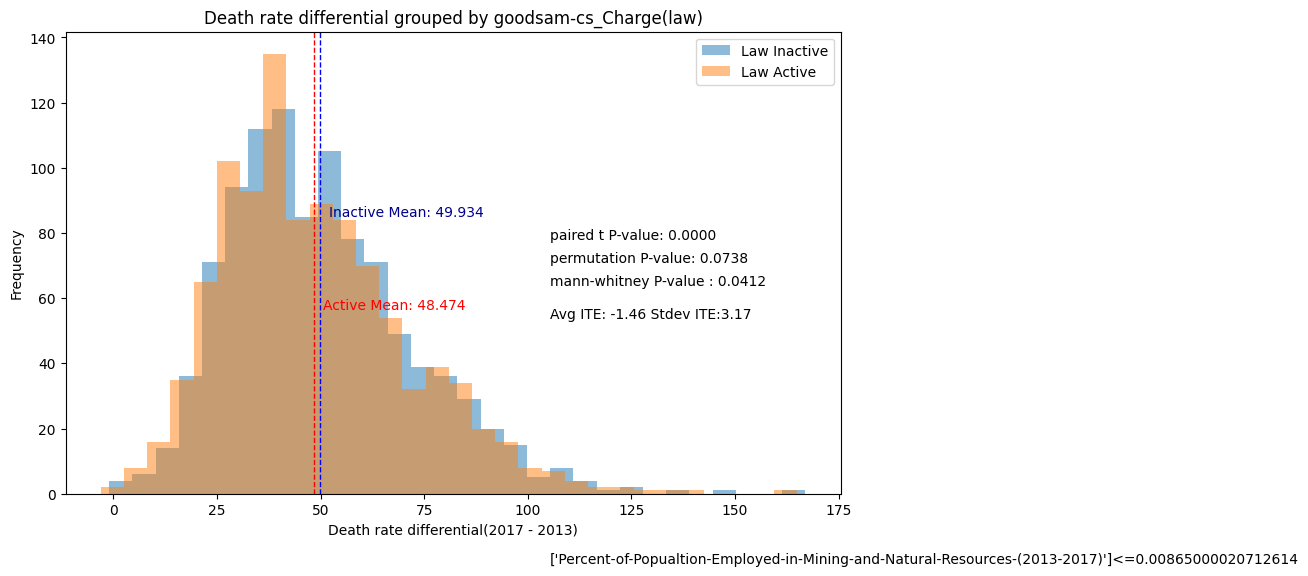


PATTERN # 27
goodsam-law
number of counties within subgroup: 676
Counter({1.0: 538, 0.0: 138})
Imbalnce Ratio: 0.25650557620817843
quantile(0.05-0.95): [ 14.959275853839397 , 108.98724514177296 ]
BART RMS: 30.335577462389136 
 Baseline RMS: 36.14553278865556
r square: 0.29563904816142605 
 nrmse: 0.14503173620465043
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.22846772546292057, 0.1941976504134702, 0.14922424903470222, 0.1906305453379553, 0.10019367818759639]
Mean Score: 0.17254276968732893
Avg ITE: 3.8150973510438204 Stdev ITE: 1.2054335768397133
PermutationTestResult(statistic=-3.8150973510438178, pvalue=0.0017, null_distribution=array([-0.29186285,  0.44235597, -0.0702945 , ...,  0.1384915 ,
        1.05488747, -1.74081681]))
TtestResult(statistic=-82.226958516703, pvalue=0.0, df=675)
MannwhitneyuResult(statistic=205928.0, pvalue=0.0008365403006688795)


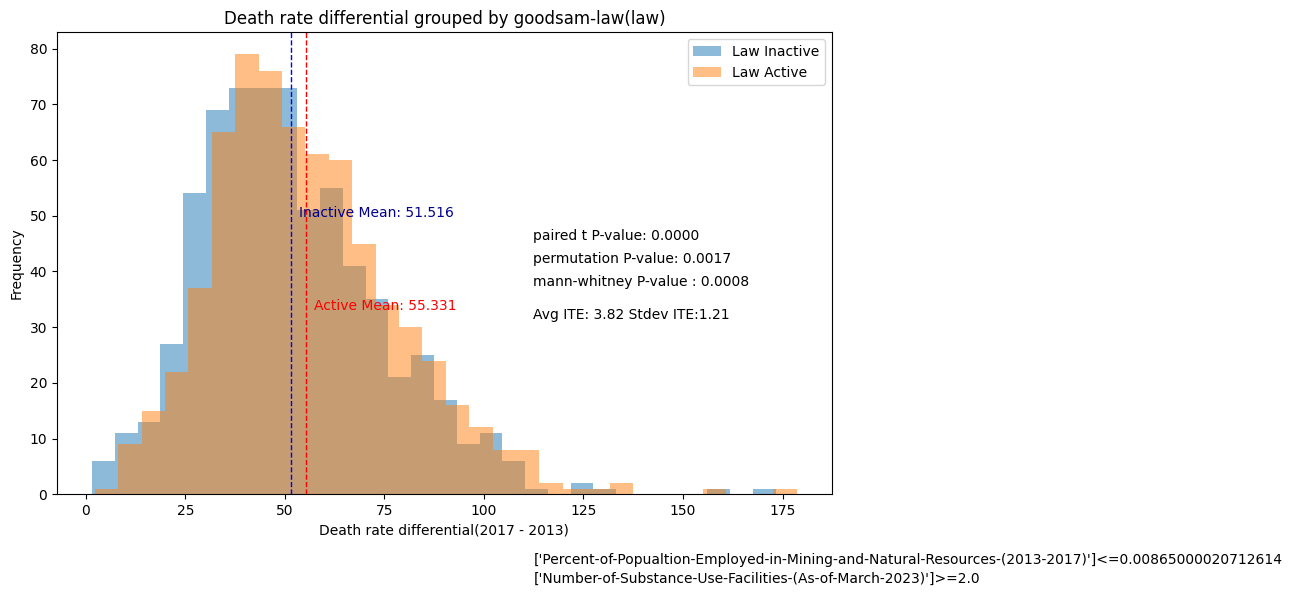


PATTERN # 28
goodsam-cs_Charge
number of counties within subgroup: 1127
Counter({0.0: 578, 1.0: 549})
Imbalnce Ratio: 0.9498269896193772
quantile(0.05-0.95): [ 17.34202374019116 , 119.03331149152348 ]
BART RMS: 30.94239945533212 
 Baseline RMS: 36.52755943344586
r square: 0.2824260491369083 
 nrmse: 0.1253099911855178
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.22824808027854715, 0.18282146292089682, 0.11658173637995943, 0.16323047790034925, 0.1359276272513388]
Mean Score: 0.1653618769462183
Avg ITE: -6.516338366637829 Stdev ITE: 3.174688329274767
PermutationTestResult(statistic=6.516338366637825, pvalue=0.0001, null_distribution=array([ 0.68072112, -1.15345965, -1.4480481 , ..., -0.77303797,
       -0.76384189, -0.21695901]))
TtestResult(statistic=68.87660420914656, pvalue=0.0, df=1126)
MannwhitneyuResult(statistic=737419.0, pvalue=1.734024140908391e-11)


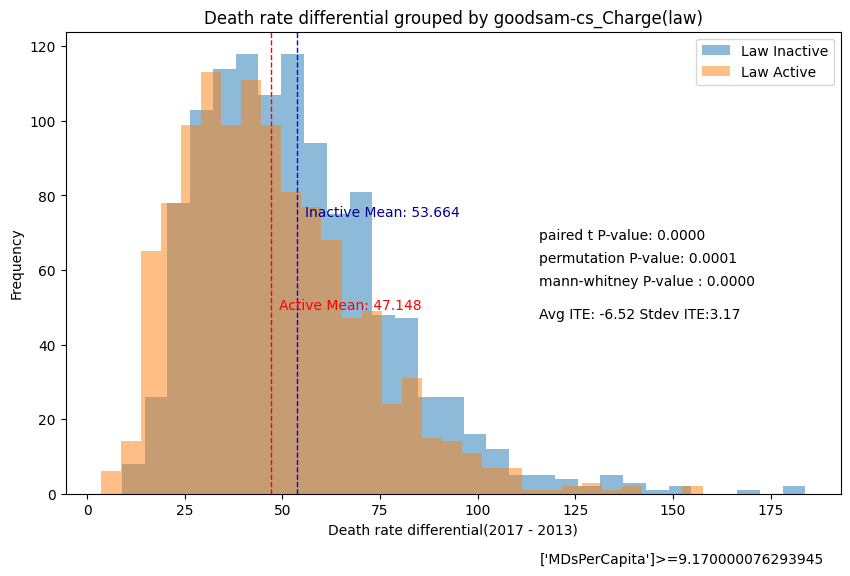


PATTERN # 29
goodsam-cs_Prosecution
number of counties within subgroup: 824
Counter({1.0: 586, 0.0: 238})
Imbalnce Ratio: 0.4061433447098976
quantile(0.05-0.95): [ 12.298909331954242 , 125.21652464321548 ]
BART RMS: 27.737597237697614 
 Baseline RMS: 34.730165203263454
r square: 0.3621420435898063 
 nrmse: 0.16214560766636887
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.19674660698839064, 0.1878686821828011, 0.20681080458688286, 0.1713507957918013, 0.10548195853113557]
Mean Score: 0.17365176961620227
Avg ITE: 7.350436121639928 Stdev ITE: 2.134408190075869
PermutationTestResult(statistic=-7.350436121639923, pvalue=0.0001, null_distribution=array([-0.1643459 ,  0.30122469, -2.42020746, ..., -1.53988118,
       -0.9166799 , -0.4040894 ]))
TtestResult(statistic=-98.79513218616178, pvalue=0.0, df=823)
MannwhitneyuResult(statistic=269188.0, pvalue=1.6954434353746468e-13)


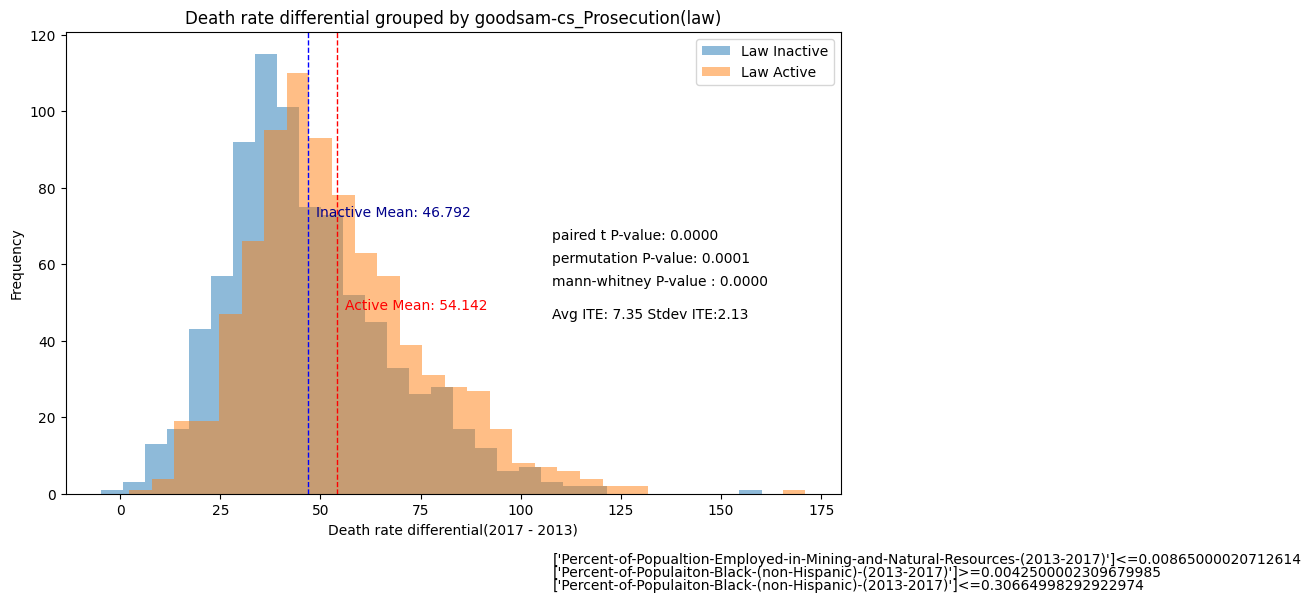

In [31]:
for i in range(26,30):
    print("\nPATTERN #",i)
    df_sub = df.copy(deep=True)
    conds = patterns_constraints[i]
    law = patterns_laws[i]

    if len(conds) != 0:
        for cond in conds:
            df_sub = df_sub.loc[eval(cond)].reset_index(drop=True)
    else:
        print("No filters in pattern")
        continue

    if law == "":
        # law  = 'goodsam-cs_Prosecution'
        print("No law in pattern")
        continue

    print(law)
    print("number of counties within subgroup:",df_sub.shape[0])


    print(Counter(df_sub[law]))
    num_instances = list(Counter(df_sub[law]).values())
    imbalance_ratio = min(num_instances) / max(num_instances)
    print("Imbalanced Data Detected! Imbalnce Ratio:", imbalance_ratio) if (imbalance_ratio < 0.1) else print("Imbalnce Ratio:",imbalance_ratio)

    patternBART(df_sub, law)

